# Time Travel Problem - Valuation Graph

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns

%matplotlib inline

In [2]:
mode = 'large'

transac_file = f"{mode}.txt"

with open(transac_file, "r") as file:
    transacs = file.read().splitlines()

comps = set() # In order to load only the data that appears in the transactions
len_trans = transacs.pop(0)
transactions = []
for x in transacs:
    transac = x.split(" ")
    transactions.append(transac)
    comps.add(transac[2])

In [3]:
direc = "Stocks\\"
load_stocks = []
counter = 0

for filename in os.listdir(direc):
    statinfo = os.stat(direc+filename)
    
    if filename.split('.us')[0].upper() in comps:
        data = pd.read_csv(direc + filename, header=0, parse_dates=["Date"])
        data.insert(1, "Company Index", counter)
        data['Stock name'] = filename.split('.us')[0].upper()
        
        load_stocks.append(data)
        counter += 1
            
print("Added a total of {} stocks.".format(counter))

df = pd.concat(load_stocks)

# This column is useless for our analysis, explain more in the text
df.drop(['OpenInt'], axis=1, inplace=True)

df.reset_index(inplace=True)
df.rename(columns={'index': 'Local Index'}, inplace=True)

Added a total of 8 stocks.


In [4]:
stocks = {} # avail stocks
balance = {} # avail money per day
portfolio = {} # virtual money from stocks, depending on stock value
avail_money = 1.0

start_date = '1960-01-01'
end_date = str(df['Date'].max().date())
dates = pd.date_range(start_date, end_date) # From 1/1/1960 till the last day present in the dataframe

In [5]:
finished_transacs = False
active_transac = transactions.pop(0) # Get the first transaction
last_price_of_stock = {}
sum_trans = 0

for x in dates:
    
    eff_df = df.loc[df['Date']==x] # The effective dataframe that deals with this specific date
    earned = 0.0
    spent = 0.0

    while pd.to_datetime(active_transac[0]) == x and finished_transacs == False:
        
        stock = active_transac[2]
        shares = int(active_transac[3])
        ID = active_transac[1]
        
        # Do transaction
        if ID == 'buy-open':
            if stock in stocks:
                stocks[stock] += shares
            else:
                stocks[stock] = shares
            price = eff_df.loc[eff_df['Stock name'] == stock].iloc[0,3] # Price Open
            #spent += 1.01*shares*price # <- in order to incorporate transaction fees
            spent += shares*price
        elif ID == 'buy-low':
            if stock in stocks:
                stocks[stock] += shares
            else:
                stocks[stock] = shares
            price = eff_df.loc[eff_df['Stock name'] == stock].iloc[0,5] # Price Low
            #spent += 1.01*shares*price
            spent += shares*price
        elif ID == 'sell-high':
            stocks[stock] -= shares
            price = eff_df.loc[eff_df['Stock name'] == stock].iloc[0,4] # Price High
            #earned += 0.99*shares*price
            earned += shares*price
        elif ID == 'sell-close':
            stocks[stock] -= shares
            price = eff_df.loc[eff_df['Stock name'] == stock].iloc[0,6] # Price Close
            #earned += 0.99*shares*price
            earned += shares*price
        # The following were omitted in version 1
        # But have to be included because of the extra restriction
        # of being able to buy stocks depending on the number of stocks you own
        elif ID == 'sell-open':
            stocks[stock] -= shares
            price = eff_df.loc[eff_df['Stock name'] == stock].iloc[0,3]
            #earned += 0.99*shares*price
            earned += shares*price
        elif ID == 'sell-low':
            stocks[stock] -= shares
            price = eff_df.loc[eff_df['Stock name'] == stock].iloc[0,5]
            #earned += 0.99*shares*price
            earned += shares*price
        elif ID == 'buy-high':
            if stock in stocks:
                stocks[stock] += shares
            else:
                stocks[stock] = shares
            price = eff_df.loc[eff_df['Stock name'] == stock].iloc[0,4]
            #spent += 1.01*shares*price
            spent += shares*price
        elif ID == 'buy-close':
            if stock in stocks:
                stocks[stock] += shares
            else:
                stocks[stock] = shares
            price = eff_df.loc[eff_df['Stock name'] == stock].iloc[0,6]
            #spent += 1.01*shares*price
            spent += shares*price
        
        if transactions:
            active_transac = transactions.pop(0)
        else:
            finished_transacs = True
    
    avail_money += earned
    avail_money -= spent
    balance[x] = avail_money
    
    # The portfolio is udpated according to the close value
    virtual_money = 0.0
    for y in stocks:
        price_stock_today = eff_df.loc[eff_df['Stock name'] == y]
        if not price_stock_today.empty:
            tprice = price_stock_today.iloc[0,6]
            last_price_of_stock[y] = tprice
            virtual_money += tprice*stocks[y]
        else:
            virtual_money += last_price_of_stock[y]*stocks[y]

    portfolio[x] = virtual_money
    
print(f'The exact total profit is {balance[dates[-1]]:.2f}$.')

The exact total profit is 707739742131.71$.


In [6]:
if not os.path.isdir("valuation"):
    os.makedirs("valuation")

bfile = open(f"valuation\\balance_{mode}.txt", "w")
for element in balance:
    bfile.write(f'{element}, {balance[element]}\n')
bfile.close()

pfile = open(f"valuation\\portfolio_{mode}.txt", "w")
for element in portfolio:
    pfile.write(f'{element}, {portfolio[element]}\n')
pfile.close()

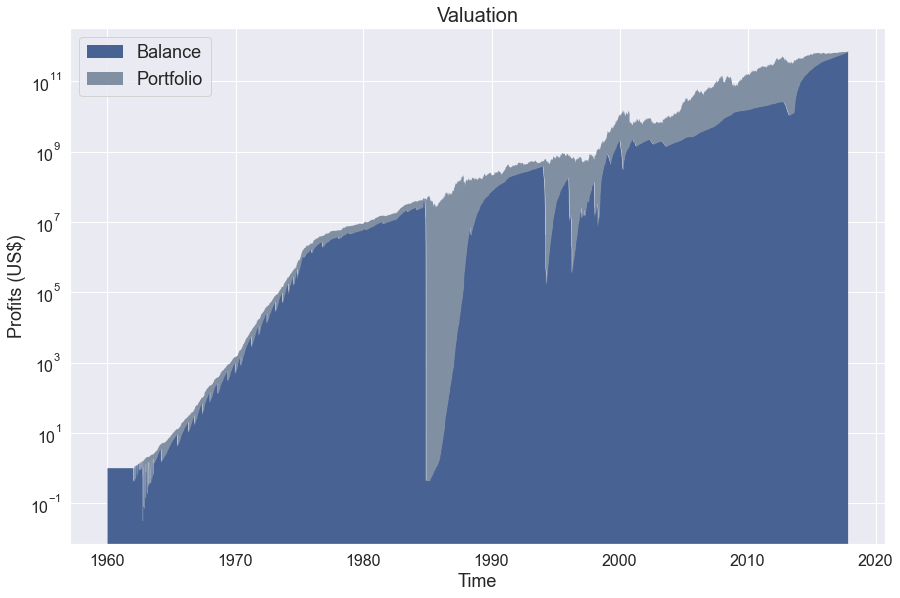

In [7]:
# Dataframe for plotting
balance_vals = pd.DataFrame.from_dict(balance, orient='index')
portfolio_vals = pd.DataFrame.from_dict(portfolio, orient='index')
balance_vals.rename(columns={0: 'Balance'}, inplace=True)
portfolio_vals.rename(columns={0: 'Portfolio'}, inplace=True)
graph_vals = balance_vals.join(portfolio_vals, how='outer')
graph_vals.insert(0, "Dates", graph_vals.index)

# Plotting
mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)
sns.set(style = "darkgrid")
colors = [mycol, mycomplcol]

xvals = graph_vals['Dates']
balvals = graph_vals['Balance']
portvals = graph_vals['Portfolio']

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14.6, 9.5)
ax.stackplot(xvals, balvals, portvals, labels=['Balance','Portfolio'], colors=colors, linewidth=0)
ax.set_title('Valuation', fontsize=20)
ax.set_yscale("log")
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Profits (US$)', fontsize=18)
ax.set_yticks([0.1, 10, 1000, 100000, 10000000, 1000000000, 100000000000])
plt.legend(loc='upper left', prop={'size': 18})
plt.savefig(f"valuation\\Valuation-{mode}.pdf", bbox_inches='tight')
plt.show()

In [8]:
# To make the graph without having to re-run the whole notebook, but simply
# load the balance and portfolio data from the saved text files:

def plot_from_files():
    
    mycol = (0.13333, 0.35294, 0.38824)
    mycomplcol = (0.6, 0.4549, 0.2078)
    sns.set(style = "darkgrid")
    colors = [mycol, mycomplcol]
    
    headers_p = ['Dates2', 'Portfolio']
    headers_b = ['Dates', 'Balance']

    imp_port = pd.read_csv(f'valuation\\portfolio_{mode}.txt', names=headers_p)

    imp_bal = pd.read_csv(f'valuation\\balance_{mode}.txt', names=headers_b, parse_dates=['Dates'])

    mixed = pd.concat([imp_port, imp_bal], axis=1)
    
    # Plotting
    imp_xvals = mixed['Dates']
    imp_balvals = mixed['Balance']
    imp_portvals = mixed['Portfolio']

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(14.6, 9.5)
    ax.stackplot(imp_xvals, imp_balvals, imp_portvals, labels=['Balance','Portfolio'], colors=colors, linewidth=0)
    ax.set_title('Valuation', fontsize=20)
    ax.set_yscale("log")
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Time', fontsize=18)
    ax.set_ylabel('Profits ($)', fontsize=18)
    ax.set_yticks([0.1, 10, 1000, 100000, 10000000, 1000000000, 100000000000])
    plt.legend(loc='upper left', prop={'size': 18})
    plt.savefig(f"valuation\\Valuation-{mode}.pdf", bbox_inches='tight')
    plt.show()
    
    return

In [9]:
#plot_from_files()